## Homework 2, CS685 Spring 2022

### This is due on May 4, submitted via Gradescope as a PDF (File>Print>Save as PDF). 100 points total.

#### IMPORTANT: After copying this notebook to your Google Drive, please paste a link to it below. To get a publicly-accessible link, hit the *Share* button at the top right, then click "Get shareable link" and copy over the result. If you fail to do this, you will receive no credit for this homework!
***LINK: *paste your link here****

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says "Write your answer here..." with your actual answer.
 
- This assignment is designed such that each cell takes a few minutes (if that) to run. If it is taking longer than that, you might have made a mistake in your code.

---

##### *How to submit this problem set:*
- Write all the answers in this Colab notebook. Once you are finished, generate a PDF via (File -> Print -> Save as PDF) and upload it to Gradescope.
  
- **Important:** check your PDF before you submit to Gradescope to make sure it exported correctly. If Colab gets confused about your syntax, it will sometimes terminate the PDF creation routine early.

- **Important:** on Gradescope, please make sure that you tag each page with the corresponding question(s). This makes it significantly easier for our graders to grade submissions, especially with the long outputs of many of these cells. We will take off points for submissions that are not tagged.

- When creating your final version of the PDF to hand in, please do a fresh restart and execute every cell in order. One handy way to do this is by clicking `Runtime -> Run All` in the notebook menu.

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your PDF. If you turn in correct answers on your PDF without code that actually generates those answers, we will consider this a serious case of cheating. See the course page for honesty policies.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

# Part 0: Setup

## Adding a hardware accelerator
The purpose of this homework is to get you acquainted with using large-scale pretrained language models specifically in the context of text generation. Since we will be training large neural networks we will attach a GPU; otherwise, training will take a very long time.

Please go to the menu and add a GPU as follows:

`Edit > Notebook Settings > Hardware accelerator > (GPU)`

Run the following cell to confirm that the GPU is detected.

In [1]:
import torch

# Confirm that the GPU is detected
 assert torch.cuda.is_available()

# # Get the GPU device name.
 device_name = torch.cuda.get_device_name()
 n_gpu = torch.cuda.device_count()
 print(f"Found device: {device_name}, n_gpu: {n_gpu}")

## Installing Hugging Face's Transformers and Additional Libraries
We will use Hugging Face's Transformers (https://github.com/huggingface/transformers), an open-source library that provides general-purpose architectures for natural language understanding and generation with a collection of various pretrained models made by the NLP community. This library will allow us to easily use pretrained models like `BERT` and perform experiments on top of them. We can use these models to solve downstream target tasks, such as text classification, question answering, sequence labeling, and text generation.

Run the following cell to install Hugging Face's Transformers library and some other useful tools. This cell will also download data used later in the assignment.

In [27]:
!pip install -q transformers==4.17.0 datasets==2.0.0 rich[jupyter]
!pip install -q googletrans==3.1.0a0
!pip install -q -U PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print('success!')

import os
import zipfile

data_file = drive.CreateFile({'id': '1zeo8FcaNUnhN660mGMNEAPvxOE4DPOnE'})
data_file.GetContentFile('hw1.zip')

# Extract data from the zipfile and put it into the current directory
with zipfile.ZipFile('hw1.zip', 'r') as zip_file:
    zip_file.extractall('./')
os.remove('hw1.zip')
# We will use hw1 as our working directory
os.chdir('hw1')
print("Data and supporting code downloaded!")

import pandas as pd
def tsv_to_csv(in_file, out_file):
    data = pd.read_csv(in_file, sep='\t')  
    data.to_csv(out_file, sep=',', index=False)    

tsv_to_csv('data/tinySST/dev.tsv', 'data/tinySST/dev.csv')
tsv_to_csv('data/tinySST/train.tsv', 'data/tinySST/train.csv')
print('finished preprocessing data')

pretrained_models_dir = './pretrained_models_dir'
if not os.path.isdir(pretrained_models_dir):
  os.mkdir(pretrained_models_dir)   # directory to save pretrained models
print('model directory created')

!pip install -q -r requirements.txt
print('extra packages installed!')

!wget -nv http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json
!wget -nv https://downloads.cs.stanford.edu/nlp/data/coqa/coqa-dev-v1.0.json
print('Download coqa dataset!')

success!
Data and supporting code downloaded!
finished preprocessing data
model directory created
extra packages installed!
2023-03-09 14:30:32 URL:http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json [49001836/49001836] -> "coqa-train-v1.0.json" [1]
2023-03-09 14:30:33 URL:https://downloads.cs.stanford.edu/nlp/data/coqa/coqa-dev-v1.0.json [9090845/9090845] -> "coqa-dev-v1.0.json" [1]
Download coqa dataset!


# Part 1. Beam Search
We're going to explore decoding from a pretrained GPT-2 model using beam search. Run the below cell to set up some beam search utilities.

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# Beam Search

def init_beam_search(model, input_ids, num_beams):
    assert len(input_ids.shape) == 2
    beam_scores = torch.zeros(num_beams, dtype=torch.float32, device=model.device)
    beam_scores[1:] = -1e9 # Break ties in first round.
    new_input_ids = input_ids.repeat_interleave(num_beams, dim=0).to(model.device)
    return new_input_ids, beam_scores


def run_beam_search_(model, tokenizer, input_text, num_beams=5, num_decode_steps=10, score_processors=[], to_cpu=True):
  
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    input_ids, beam_scores = init_beam_search(model, input_ids, num_beams)

    token_scores = beam_scores.clone().view(num_beams, 1)

    model_kwargs = {}
    for i in range(num_decode_steps):
        model_inputs = model.prepare_inputs_for_generation(input_ids, **model_kwargs)
        outputs = model(**model_inputs, return_dict=True)
        next_token_logits = outputs.logits[:, -1, :]
        vocab_size = next_token_logits.shape[-1]
        this_token_scores = torch.log_softmax(next_token_logits, -1)

        # Process token scores.
        processed_token_scores = this_token_scores
        for processor in score_processors:
            processed_token_scores = processor(input_ids, processed_token_scores)

        # Update beam scores.
        next_token_scores = processed_token_scores + beam_scores.unsqueeze(-1)

        # Reshape for beam-search.
        next_token_scores = next_token_scores.view(num_beams * vocab_size)

        # Find top-scoring beams.
        next_token_scores, next_tokens = torch.topk(
            next_token_scores, num_beams, dim=0, largest=True, sorted=True
        )

        # Transform tokens since we reshaped earlier.
        next_indices = torch.div(next_tokens, vocab_size, rounding_mode="floor") # This is equivalent to `next_tokens // vocab_size`
        next_tokens = next_tokens % vocab_size

        # Update tokens.
        input_ids = torch.cat([input_ids[next_indices, :], next_tokens.unsqueeze(-1)], dim=-1)

        # Update beam scores.
        beam_scores = next_token_scores

        # Update token scores.

        # UNCOMMENT: To use original scores instead.
        # token_scores = torch.cat([token_scores[next_indices, :], this_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)
        token_scores = torch.cat([token_scores[next_indices, :], processed_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)

        # Update hidden state.
        model_kwargs = model._update_model_kwargs_for_generation(outputs, model_kwargs, is_encoder_decoder=False)
        model_kwargs["past"] = model._reorder_cache(model_kwargs["past"], next_indices)

    def transfer(x):
      return x.cpu() if to_cpu else x

    return {
        "output_ids": transfer(input_ids),
        "beam_scores": transfer(beam_scores),
        "token_scores": transfer(token_scores)
    }


def run_beam_search(*args, **kwargs):
    with torch.inference_mode():
        return run_beam_search_(*args, **kwargs)


# Add support for colored printing and plotting.

from rich import print as rich_print

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm

RICH_x = np.linspace(0.0, 1.0, 50)
RICH_rgb = (cm.get_cmap(plt.get_cmap('RdYlBu'))(RICH_x)[:, :3] * 255).astype(np.int32)[range(5, 45, 5)]

def print_with_probs(words, probs, prefix=None):
  def fmt(x, p, is_first=False):
    ix = int(p * RICH_rgb.shape[0])
    r, g, b = RICH_rgb[ix]
    if is_first:
      return f'[bold rgb(0,0,0) on rgb({r},{g},{b})]{x}'
    else:
      return f'[bold rgb(0,0,0) on rgb({r},{g},{b})] {x}'
  output = []
  if prefix is not None:
    output.append(prefix)
  for i, (x, p) in enumerate(zip(words, probs)):
    output.append(fmt(x, p, is_first=i == 0))
  rich_print(''.join(output))

# DEMO

# Show range of colors.

for i in range(RICH_rgb.shape[0]):
  r, g, b = RICH_rgb[i]
  rich_print(f'[bold rgb(0,0,0) on rgb({r},{g},{b})]hello world rgb({r},{g},{b})')

# Example with words and probabilities.

words = ['the', 'brown', 'fox']
probs = [0.14, 0.83, 0.5]
print_with_probs(words, probs)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

hello world rgb(215,49,39)

hello world rgb(244,111,68)

hello world rgb(253,176,99)

hello world rgb(254,226,147)

hello world rgb(251,253,196)

hello world rgb(217,239,246)

hello world rgb(163,210,229)

hello world rgb(108,164,204)

the brown fox

## Question 1.1 (5 points)

Run the cell below. It produces a sequence of tokens using beam search and the provided prefix.

In [4]:
num_beams = 5
num_decode_steps = 10
input_text = 'The brown fox jumps'

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)
for i, tokens in enumerate(beam_output['output_ids']):
    score = beam_output['beam_scores'][i]
    print(i, round(score.item() / tokens.shape[-1], 3), tokenizer.decode(tokens, skip_special_tokens=True))


0 -1.106 The brown fox jumps out of the fox's mouth, and the fox
1 -1.168 The brown fox jumps out of the fox's cage, and the fox
2 -1.182 The brown fox jumps out of the fox's mouth and starts to run
3 -1.192 The brown fox jumps out of the fox's mouth and begins to lick
4 -1.199 The brown fox jumps out of the fox's mouth and begins to bite


To get you more acquainted with the code, let's do a simple exercise first. Write your own code in the cell below to generate 3 tokens with a beam size of 4, and then print out the **third most probable** output sequence found during the search. Use the same prefix as above.

In [5]:
input_text = 'The brown fox jumps'

# WRITE YOUR CODE HERE!
num_beams = 4
num_decode_steps = 3

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)
scores = []
gens = []
for i, tokens in enumerate(beam_output['output_ids']):
    score = beam_output['beam_scores'][i]
    gen = tokenizer.decode(tokens, skip_special_tokens=True)
    scores.append(score)
    gens.append(gen)

print(gens[scores.index(max(scores))])

The brown fox jumps out of the


## Question 1.2 (10 points)

Run the cell below to visualize the probabilities the model assigns for each generated word when using beam search with beam size 1 (i.e., greedy decoding).

Visualizeation with plot:


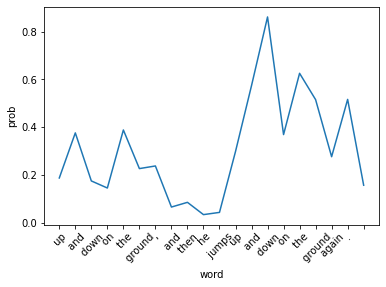

Visualization with colored text (red for lower probability, and blue for higher):


The  brown  fox  jumps up  and  down  on  the  ground ,  and  then  he  jumps  up  and  down  on  the  ground  
again . 

In [6]:
input_text = 'The brown fox jumps'
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=1, num_decode_steps=20)
probs = beam_output['token_scores'][0, 1:].exp()
output_subwords = [tokenizer.decode(tok, skip_special_tokens=True) for tok in beam_output['output_ids'][0]]

print('Visualizeation with plot:')

fig, ax = plt.subplots()
plt.plot(range(len(probs)), probs)
ax.set_xticks(range(len(probs)))
ax.set_xticklabels(output_subwords[-len(probs):], rotation = 45)
plt.xlabel('word')
plt.ylabel('prob')
plt.show()

print('Visualization with colored text (red for lower probability, and blue for higher):')

print_with_probs(output_subwords[-len(probs):], probs, ' '.join(output_subwords[:-len(probs)]))

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

Why does the model assign a higher probability to tokens generated later than to tokens generated earlier?

Tokens are generated looking through the other possible tokens in n steps. We take combined probabilites of all of them. So closer to the root, smaller the probability assigned usually.



## Question 1.3 (10 points)

Run the cell below to visualize the word probabilities when using different beam sizes.

Visualization with plot:


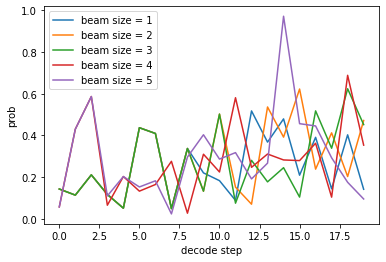

Model predictions:
1 -0.9706197796445905 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was
2 -0.9286185177889738 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. The boy was playing with a stick, and the boy
3 -0.9597567933978457 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. The boy, who had been playing with a stick,
4 -0.9205130952777285 Once upon a time, in a barn near a farm house, there was a young girl who had been brought up by her mother. She had been brought up by
5 -0.9058790495901397 Once upon a time, in a barn near a farm house, there was a man who had been living in the house for a long time. He was a man


In [7]:
input_text = 'Once upon a time, in a barn near a farm house,'
num_decode_steps = 20
model.cuda()

beam_size_list = [1, 2, 3, 4, 5]
output_list = []
probs_list = []
for bm in beam_size_list:
  beam_output = run_beam_search(model, tokenizer, input_text, num_beams=bm, num_decode_steps=num_decode_steps)
  output_list.append(beam_output)
  probs = beam_output['token_scores'][0, 1:].exp()
  probs_list.append((bm, probs))

print('Visualization with plot:')
fig, ax = plt.subplots()
for bm, probs in probs_list:
  plt.plot(range(len(probs)), probs, label=f'beam size = {bm}')
plt.xlabel('decode step')
plt.ylabel('prob')
plt.legend(loc='best')
plt.show()

print('Model predictions:')
for bm, beam_output in zip(beam_size_list, output_list):
  tokens = beam_output['output_ids'][0]
  print(bm, beam_output['beam_scores'][0].item() / tokens.shape[-1], tokenizer.decode(tokens, skip_special_tokens=True))

The `Model Predictions` section above includes the average cumulative log probability of each sequence. Does higher beam size always guarantee a higher probability final sequence? Why or why not?

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

Actually we can see that higher beam size has lower cummlative probability in this case. So we can say it doesn't guarantee.

## Question 1.4 (15 points)

Beam search often results in repetition in the predicted tokens. In the following cell we pass a score processor called `WordBlock` to `run_beam_search`. At each time step, it reduces the probability for any previously seen word so that it is not generated again.

Run the cell to see how the output of beam search changes with and without using `WordBlock`.

In [8]:
import collections

class WordBlock:
    def __call__(self, input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            for x in input_ids[batch_idx].tolist():
                scores[batch_idx, x] = -1e9
        return scores

input_text = 'Once upon a time, in a barn near a farm house,'
num_beams = 1

print('Beam Search')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))

print('Beam Search w/ Word Block')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[WordBlock()])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))


Beam Search
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a
Beam Search w/ Word Block
Once upon a time, in a barn near a farm house, the young girl was playing with her father's dog. She had been told that she would be given to him by his wife and he could take care of it for herself if needed; but when they


Is `WordBlock` a practical way to prevent repetition in beam search? What (if anything) could go wrong when using `WordBlock`?

It's not a good way since we're at the same time blocking stop words. It may cause a meaningless sentence to appear.

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

## Question 1.5 (20 points)

Use the previous `WordBlock` example to write a new score processor called `BeamBlock`. Instead of uni-grams, your implementation should prevent tri-grams from appearing more than once in the sequence.

Note: This technique is called "beam blocking" and is described [here](https://arxiv.org/pdf/1705.04304.pdf) (section 2.5). Also, for this assignment you do not need to re-normalize your output distribution after masking values, although typically re-normalization is done.

Write your code in the indicated section in the below cell.

In [9]:
import collections

class BeamBlock:
    def __call__(self, input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            # WRITE YOUR CODE HERE!
            pass
        return scores

input_text = 'Once upon a time, in a barn near a farm house,'
num_beams = 1

print('Beam Search')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))

print('Beam Search w/ Beam Block')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[BeamBlock()])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))


Beam Search
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a
Beam Search w/ Beam Block
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a


# Part 2. Language Model Fine-tuning
Now, we'll switch over to *fine-tuning* a pretrained language model. For this task, we'll use data from the [Conversational Question Answering dataset (CoQA)](https://stanfordnlp.github.io/coqa/). The CoQA dataset includes tuples of (story text, question, answers), and we'll only be using the story text which come from various sources including children's stories, news passages, and wikipedia.

Run the below cell to set some stuff up.

In [10]:
# Copied from huggingface examples.
# 
# Modified to include the following features:
# - Run as a command using arguments pass as a dictionary.
# - Returns the model before and after fine-tuning.

#!/usr/bin/env python
# coding=utf-8
# Copyright 2020 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Fine-tuning the library models for causal language modeling (GPT, GPT-2, CTRL, ...) on a text file or a dataset.
Here is the full list of checkpoints on the hub that can be fine-tuned by this script:
https://huggingface.co/models?filter=text-generation
"""
# You can also adapt this script on your own causal language modeling task. Pointers for this are left as comments.

import logging
import math
import os
import sys
from dataclasses import dataclass, field
from itertools import chain
from typing import Optional

import datasets
from datasets import load_dataset, load_metric

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    default_data_collator,
    is_torch_tpu_available,
    set_seed,
)
from transformers.testing_utils import CaptureLogger
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version
from transformers.utils.versions import require_version

import copy
import torch


# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
# check_min_version("4.18.0.dev0")

# require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/language-modeling/requirements.txt")

logger = logging.getLogger(__name__)


MODEL_CONFIG_CLASSES = list(MODEL_FOR_CAUSAL_LM_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)


@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default=None,
        metadata={
            "help": "The model checkpoint for weights initialization."
            "Don't set if you want to train a model from scratch."
        },
    )
    model_type: Optional[str] = field(
        default=None,
        metadata={"help": "If training from scratch, pass a model type from the list: " + ", ".join(MODEL_TYPES)},
    )
    config_overrides: Optional[str] = field(
        default=None,
        metadata={
            "help": "Override some existing default config settings when a model is trained from scratch. Example: "
            "n_embd=10,resid_pdrop=0.2,scale_attn_weights=false,summary_type=cls_index"
        },
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": "Will use the token generated when running `transformers-cli login` (necessary to use this script "
            "with private models)."
        },
    )

    def __post_init__(self):
        if self.config_overrides is not None and (self.config_name is not None or self.model_name_or_path is not None):
            raise ValueError(
                "--config_overrides can't be used in combination with --config_name or --model_name_or_path"
            )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    train_file: Optional[str] = field(default=None, metadata={"help": "The input training data file (a text file)."})
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
            "value if set."
        },
    )

    block_size: Optional[int] = field(
        default=None,
        metadata={
            "help": "Optional input sequence length after tokenization. "
            "The training dataset will be truncated in block of this size for training. "
            "Default to the model max input length for single sentence inputs (take into account special tokens)."
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    validation_split_percentage: Optional[int] = field(
        default=5,
        metadata={
            "help": "The percentage of the train set used as validation set in case there's no validation split"
        },
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    keep_linebreaks: bool = field(
        default=True, metadata={"help": "Whether to keep line breaks when using TXT files or not."}
    )

    def __post_init__(self):
        if self.dataset_name is None and self.train_file is None and self.validation_file is None:
            raise ValueError("Need either a dataset name or a training/validation file.")
        else:
            if self.train_file is not None:
                extension = self.train_file.split(".")[-1]
                assert extension in ["csv", "json", "txt"], "`train_file` should be a csv, a json or a txt file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension in ["csv", "json", "txt"], "`validation_file` should be a csv, a json or a txt file."


def run_clm(args_as_dict, debug_state={}):
    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

    parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
    model_args, data_args, training_args = parser.parse_dict(args_as_dict)
    # if len(sys.argv) == 2 and sys.argv[1].endswith(".json"):
    #     # If we pass only one argument to the script and it's the path to a json file,
    #     # let's parse it to get our arguments.
    #     model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath(sys.argv[1]))
    # else:
    #     model_args, data_args, training_args = parser.parse_args_into_dataclasses()

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )

    log_level = training_args.get_process_log_level()
    logger.setLevel(log_level)
    datasets.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()

    # Log on each process the small summary:
    logger.warning(
        f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
        + f"distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
    )
    logger.info(f"Training/evaluation parameters {training_args}")

    # Detecting last checkpoint.
    last_checkpoint = None
    if os.path.isdir(training_args.output_dir) and training_args.do_train and not training_args.overwrite_output_dir:
        last_checkpoint = get_last_checkpoint(training_args.output_dir)
        if last_checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
            raise ValueError(
                f"Output directory ({training_args.output_dir}) already exists and is not empty. "
                "Use --overwrite_output_dir to overcome."
            )
        elif last_checkpoint is not None and training_args.resume_from_checkpoint is None:
            logger.info(
                f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
                "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
            )

    # Set seed before initializing model.
    set_seed(training_args.seed)

    # Get the datasets: you can either provide your own CSV/JSON/TXT training and evaluation files (see below)
    # or just provide the name of one of the public datasets available on the hub at https://huggingface.co/datasets/
    # (the dataset will be downloaded automatically from the datasets Hub).
    #
    # For CSV/JSON files, this script will use the column called 'text' or the first column if no column called
    # 'text' is found. You can easily tweak this behavior (see below).
    #
    # In distributed training, the load_dataset function guarantee that only one local process can concurrently
    # download the dataset.
    if data_args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        raw_datasets = load_dataset(
            data_args.dataset_name, data_args.dataset_config_name, cache_dir=model_args.cache_dir
        )
        if "validation" not in raw_datasets.keys():
            raw_datasets["validation"] = load_dataset(
                data_args.dataset_name,
                data_args.dataset_config_name,
                split=f"train[:{data_args.validation_split_percentage}%]",
                cache_dir=model_args.cache_dir,
            )
            raw_datasets["train"] = load_dataset(
                data_args.dataset_name,
                data_args.dataset_config_name,
                split=f"train[{data_args.validation_split_percentage}%:]",
                cache_dir=model_args.cache_dir,
            )
    else:
        data_files = {}
        dataset_args = {}
        if data_args.train_file is not None:
            data_files["train"] = data_args.train_file
        if data_args.validation_file is not None:
            data_files["validation"] = data_args.validation_file
        extension = (
            data_args.train_file.split(".")[-1]
            if data_args.train_file is not None
            else data_args.validation_file.split(".")[-1]
        )
        if extension == "txt":
            extension = "text"
            dataset_args["keep_linebreaks"] = data_args.keep_linebreaks
        raw_datasets = load_dataset(extension, data_files=data_files, cache_dir=model_args.cache_dir, **dataset_args)
        # If no validation data is there, validation_split_percentage will be used to divide the dataset.
        if "validation" not in raw_datasets.keys():
            raw_datasets["validation"] = load_dataset(
                extension,
                data_files=data_files,
                split=f"train[:{data_args.validation_split_percentage}%]",
                cache_dir=model_args.cache_dir,
                **dataset_args,
            )
            raw_datasets["train"] = load_dataset(
                extension,
                data_files=data_files,
                split=f"train[{data_args.validation_split_percentage}%:]",
                cache_dir=model_args.cache_dir,
                **dataset_args,
            )

    # See more about loading any type of standard or custom dataset (from files, python dict, pandas DataFrame, etc) at
    # https://huggingface.co/docs/datasets/loading_datasets.html.

    # Load pretrained model and tokenizer
    #
    # Distributed training:
    # The .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.

    config_kwargs = {
        "cache_dir": model_args.cache_dir,
        "revision": model_args.model_revision,
        "use_auth_token": True if model_args.use_auth_token else None,
    }
    if model_args.config_name:
        config = AutoConfig.from_pretrained(model_args.config_name, **config_kwargs)
    elif model_args.model_name_or_path:
        config = AutoConfig.from_pretrained(model_args.model_name_or_path, **config_kwargs)
    else:
        config = CONFIG_MAPPING[model_args.model_type]()
        logger.warning("You are instantiating a new config instance from scratch.")
        if model_args.config_overrides is not None:
            logger.info(f"Overriding config: {model_args.config_overrides}")
            config.update_from_string(model_args.config_overrides)
            logger.info(f"New config: {config}")

    tokenizer_kwargs = {
        "cache_dir": model_args.cache_dir,
        "use_fast": model_args.use_fast_tokenizer,
        "revision": model_args.model_revision,
        "use_auth_token": True if model_args.use_auth_token else None,
    }
    if model_args.tokenizer_name:
        tokenizer = AutoTokenizer.from_pretrained(model_args.tokenizer_name, **tokenizer_kwargs)
    elif model_args.model_name_or_path:
        tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path, **tokenizer_kwargs)
    else:
        raise ValueError(
            "You are instantiating a new tokenizer from scratch. This is not supported by this script."
            "You can do it from another script, save it, and load it from here, using --tokenizer_name."
        )

    debug_state['tokenizer'] = tokenizer

    if model_args.model_name_or_path:
        model = AutoModelForCausalLM.from_pretrained(
            model_args.model_name_or_path,
            from_tf=bool(".ckpt" in model_args.model_name_or_path),
            config=config,
            cache_dir=model_args.cache_dir,
            revision=model_args.model_revision,
            use_auth_token=True if model_args.use_auth_token else None,
        )
    else:
        model = AutoModelForCausalLM.from_config(config)
        n_params = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())
        logger.info(f"Training new model from scratch - Total size={n_params/2**20:.2f}M params")

    model.resize_token_embeddings(len(tokenizer))

    model_before_finetuning = debug_state["model_before_finetuning"] = copy.deepcopy(model)

    # Preprocessing the datasets.
    # First we tokenize all the texts.
    if training_args.do_train:
        column_names = raw_datasets["train"].column_names
    else:
        column_names = raw_datasets["validation"].column_names
    text_column_name = "text" if "text" in column_names else column_names[0]

    if args_as_dict.get('text_column_name', None) is not None:
        text_column_name = args_as_dict['text_column_name']

    # since this will be pickled to avoid _LazyModule error in Hasher force logger loading before tokenize_function
    tok_logger = transformers.utils.logging.get_logger("transformers.tokenization_utils_base")

    def tokenize_function(examples):
        with CaptureLogger(tok_logger) as cl:
            output = tokenizer(examples[text_column_name])
        # clm input could be much much longer than block_size
        if "Token indices sequence length is longer than the" in cl.out:
            tok_logger.warning(
                "^^^^^^^^^^^^^^^^ Please ignore the warning above - this long input will be chunked into smaller bits before being passed to the model."
            )
        return output

    with training_args.main_process_first(desc="dataset map tokenization"):
        tokenized_datasets = raw_datasets.map(
            tokenize_function,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on dataset",
        )

    if data_args.block_size is None:
        block_size = tokenizer.model_max_length
        if block_size > 1024:
            logger.warning(
                f"The tokenizer picked seems to have a very large `model_max_length` ({tokenizer.model_max_length}). "
                "Picking 1024 instead. You can change that default value by passing --block_size xxx."
            )
            block_size = 1024
    else:
        if data_args.block_size > tokenizer.model_max_length:
            logger.warning(
                f"The block_size passed ({data_args.block_size}) is larger than the maximum length for the model"
                f"({tokenizer.model_max_length}). Using block_size={tokenizer.model_max_length}."
            )
        block_size = min(data_args.block_size, tokenizer.model_max_length)

    debug_state['block_size'] = block_size

    # Main data processing function that will concatenate all texts from our dataset and generate chunks of block_size.
    def group_texts(examples):
        # Concatenate all texts.
        concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
        total_length = len(concatenated_examples[list(examples.keys())[0]])
        # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
        if total_length >= block_size:
            total_length = (total_length // block_size) * block_size
        # Split by chunks of max_len.
        result = {
            k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
            for k, t in concatenated_examples.items()
        }
        result["labels"] = result["input_ids"].copy()
        return result

    # Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a remainder
    # for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value might be slower
    # to preprocess.
    #
    # To speed up this part, we use multiprocessing. See the documentation of the map method for more information:
    # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map

    with training_args.main_process_first(desc="grouping texts together"):
        lm_datasets = tokenized_datasets.map(
            group_texts,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            load_from_cache_file=not data_args.overwrite_cache,
            desc=f"Grouping texts in chunks of {block_size}",
        )

    if training_args.do_train:
        if "train" not in tokenized_datasets:
            raise ValueError("--do_train requires a train dataset")
        train_dataset = lm_datasets["train"]
        if data_args.max_train_samples is not None:
            max_train_samples = min(len(train_dataset), data_args.max_train_samples)
            train_dataset = train_dataset.select(range(max_train_samples))

    if training_args.do_eval:
        if "validation" not in tokenized_datasets:
            raise ValueError("--do_eval requires a validation dataset")
        eval_dataset = lm_datasets["validation"]
        if data_args.max_eval_samples is not None:
            max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
            eval_dataset = eval_dataset.select(range(max_eval_samples))

        def preprocess_logits_for_metrics(logits, labels):
            if isinstance(logits, tuple):
                # Depending on the model and config, logits may contain extra tensors,
                # like past_key_values, but logits always come first
                logits = logits[0]
            return logits.argmax(dim=-1)

        metric = load_metric("accuracy")

        def compute_metrics(eval_preds):
            preds, labels = eval_preds
            # preds have the same shape as the labels, after the argmax(-1) has been calculated
            # by preprocess_logits_for_metrics but we need to shift the labels
            labels = labels[:, 1:].reshape(-1)
            preds = preds[:, :-1].reshape(-1)
            return metric.compute(predictions=preds, references=labels)

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset if training_args.do_train else None,
        eval_dataset=eval_dataset if training_args.do_eval else None,
        tokenizer=tokenizer,
        # Data collator will default to DataCollatorWithPadding, so we change it.
        data_collator=default_data_collator,
        compute_metrics=compute_metrics if training_args.do_eval and not is_torch_tpu_available() else None,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics
        if training_args.do_eval and not is_torch_tpu_available()
        else None,
    )

    # Training
    model_after_finetuning = debug_state["model_after_finetuning"] = None
    if training_args.do_train:
        checkpoint = None
        if training_args.resume_from_checkpoint is not None:
            checkpoint = training_args.resume_from_checkpoint
        elif last_checkpoint is not None:
            checkpoint = last_checkpoint
        train_result = trainer.train(resume_from_checkpoint=checkpoint)
        trainer.save_model()  # Saves the tokenizer too for easy upload

        metrics = train_result.metrics

        max_train_samples = (
            data_args.max_train_samples if data_args.max_train_samples is not None else len(train_dataset)
        )
        metrics["train_samples"] = min(max_train_samples, len(train_dataset))

        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

        model_after_finetuning = debug_state["model_after_finetuning"] = model

    # Evaluation
    if training_args.do_eval:
        logger.info("*** Evaluate ***")

        metrics = trainer.evaluate()

        max_eval_samples = data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)
        metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))
        try:
            perplexity = math.exp(metrics["eval_loss"])
        except OverflowError:
            perplexity = float("inf")
        metrics["perplexity"] = perplexity

        trainer.log_metrics("eval", metrics)
        trainer.save_metrics("eval", metrics)

    kwargs = {"finetuned_from": model_args.model_name_or_path, "tasks": "text-generation"}
    if data_args.dataset_name is not None:
        kwargs["dataset_tags"] = data_args.dataset_name
        if data_args.dataset_config_name is not None:
            kwargs["dataset_args"] = data_args.dataset_config_name
            kwargs["dataset"] = f"{data_args.dataset_name} {data_args.dataset_config_name}"
        else:
            kwargs["dataset"] = data_args.dataset_name

    # Should call this after `run_clm` to free up some GPU memory.
    # Some GPU memory will still be reserved, so if you need to re-run
    # fine-tuning, then you may need to click "Runtime -> Restart Runtime", although
    # this will reset all previously run cells.
    model_before_finetuning.cpu()
    model_after_finetuning.cpu()
    torch.cuda.empty_cache()

    return model_before_finetuning, model_after_finetuning


from tqdm import tqdm
import collections
import numpy as np

def compute_rouge(model, tokenizer, dataset, n=3):

  def count_ngrams(tokens, n):
    c = collections.Counter()
    for size in range(1, n + 1):
      for end in range(size, len(tokens) + 1):
        ngram = tuple(tokens[end - size:end])
        c[ngram] += 1
    return c

  def rouge(gold, pred, n):
    gold_c = count_ngrams(gold, n)
    pred_c = count_ngrams(pred, n)
    overlap = sum([pred_c[ngram] for ngram in gold_c.keys()])
    total = sum(gold_c.values())
    return overlap / total

  with torch.inference_mode():
    m = []
    for p1, p2 in tqdm(dataset, desc=f'Compute ROGUE-{n}'):
      # TODO: Does this include the correct values for beam search?
      beam_output = run_beam_search(
          model,
          tokenizer,
          p1,
          num_beams=3,
          num_decode_steps=32)
      pred = tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True).split('.', 2)[1].strip() + '.'
      pred_ids = tokenizer(pred, return_tensors="pt")['input_ids'][0].tolist()
      # p1_tensor = tokenizer(p1, return_tensors="pt")['input_ids']
      gold_ids = tokenizer(p2, return_tensors="pt")['input_ids'][0].tolist()
      m.append(rouge(gold_ids, pred_ids, n))

    return np.mean(m)


def compute_perplexity(model, tokenizer, dataset):

  with torch.inference_mode():
    n = 0
    m = []
    for p1, p2 in tqdm(dataset, desc='Compute Perplexity'):
      p1_tensor = tokenizer(p1, return_tensors="pt")['input_ids']
      p2_tensor = tokenizer(p2, return_tensors="pt")['input_ids']
      input_ids = torch.cat([p1_tensor, p2_tensor], 1).to(model.device)
      target = input_ids.clone()
      target[:, :p1_tensor.shape[1]] = -100
      target_length = p2_tensor.shape[1]
      n += target_length

      nll = model(input_ids=input_ids, labels=target)[0] * target_length
      m.append(nll)

    return torch.exp(torch.cat([x.view(1) for x in m], 0).sum() / n)


def preprocess_coqa(dataset):
    new_dataset = []
    skipped = 0
    for text in dataset:
        parts = text.split('. ', 2)
        if len(parts) <= 1:
            skipped += 1
            continue
        p1 = parts[0].strip() + '.'
        p2 = parts[1].strip() + '.'
        new_dataset.append((p1, p2))

    return new_dataset

# Part 3: Data Augmentation via Backtranslation
The last part of this homework involves data augmentation of an NLP classifier via backtranslation. Now run the below cell to set up some fine-tuning code.

In [19]:
#!/usr/bin/env python
# coding=utf-8
# Copyright 2020 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Finetuning the library models for sequence classification on GLUE."""
# You can also adapt this script on your own text classification task. Pointers for this are left as comments.

import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional

import datasets
import numpy as np
from datasets import load_dataset, load_metric

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version
from transformers.utils.versions import require_version

from transformers import glue_processors
from transformers.data.processors.utils import InputExample
from langdetect import detect


# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
# check_min_version("4.18.0.dev0")

# require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/text-classification/requirements.txt")

task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

logger = logging.getLogger(__name__)


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.

    Using `HfArgumentParser` we can turn this class
    into argparse arguments to be able to specify them on
    the command line.
    """

    task_name: Optional[str] = field(
        default=None,
        metadata={"help": "The name of the task to train on: " + ", ".join(task_to_keys.keys())},
    )
    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    max_seq_length: int = field(
        default=128,
        metadata={
            "help": "The maximum total input sequence length after tokenization. Sequences longer "
            "than this will be truncated, sequences shorter will be padded."
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached preprocessed datasets or not."}
    )
    pad_to_max_length: bool = field(
        default=True,
        metadata={
            "help": "Whether to pad all samples to `max_seq_length`. "
            "If False, will pad the samples dynamically when batching to the maximum length in the batch."
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
            "value if set."
        },
    )
    max_predict_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of prediction examples to this "
            "value if set."
        },
    )
    train_file: Optional[str] = field(
        default=None, metadata={"help": "A csv or a json file containing the training data."}
    )
    validation_file: Optional[str] = field(
        default=None, metadata={"help": "A csv or a json file containing the validation data."}
    )
    test_file: Optional[str] = field(default=None, metadata={"help": "A csv or a json file containing the test data."})

    def __post_init__(self):
        if self.task_name is not None:
            self.task_name = self.task_name.lower()
            if self.task_name not in task_to_keys.keys():
                raise ValueError("Unknown task, you should pick one in " + ",".join(task_to_keys.keys()))
        elif self.dataset_name is not None:
            pass
        elif self.train_file is None or self.validation_file is None:
            raise ValueError("Need either a GLUE task, a training/validation file or a dataset name.")
        else:
            train_extension = self.train_file.split(".")[-1]
            assert train_extension in ["csv", "json"], "`train_file` should be a csv or a json file."
            validation_extension = self.validation_file.split(".")[-1]
            assert (
                validation_extension == train_extension
            ), "`validation_file` should have the same extension (csv or json) as `train_file`."


@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": "Will use the token generated when running `transformers-cli login` (necessary to use this script "
            "with private models)."
        },
    )


def do_target_task_finetuning(args_as_dict):
    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

    parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
    model_args, data_args, training_args = parser.parse_dict(args_as_dict)

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )

    log_level = training_args.get_process_log_level()
    logger.setLevel(log_level)
    datasets.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()

    # Log on each process the small summary:
    logger.warning(
        f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
        + f"distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
    )
    logger.info(f"Training/evaluation parameters {training_args}")

    # Detecting last checkpoint.
    last_checkpoint = None
    if os.path.isdir(training_args.output_dir) and training_args.do_train and not training_args.overwrite_output_dir:
        last_checkpoint = get_last_checkpoint(training_args.output_dir)
        if last_checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
            raise ValueError(
                f"Output directory ({training_args.output_dir}) already exists and is not empty. "
                "Use --overwrite_output_dir to overcome."
            )
        elif last_checkpoint is not None and training_args.resume_from_checkpoint is None:
            logger.info(
                f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
                "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
            )

    # Set seed before initializing model.
    set_seed(training_args.seed)

    # Get the datasets: you can either provide your own CSV/JSON training and evaluation files (see below)
    # or specify a GLUE benchmark task (the dataset will be downloaded automatically from the datasets Hub).
    #
    # For CSV/JSON files, this script will use as labels the column called 'label' and as pair of sentences the
    # sentences in columns called 'sentence1' and 'sentence2' if such column exists or the first two columns not named
    # label if at least two columns are provided.
    #
    # If the CSVs/JSONs contain only one non-label column, the script does single sentence classification on this
    # single column. You can easily tweak this behavior (see below)
    #
    # In distributed training, the load_dataset function guarantee that only one local process can concurrently
    # download the dataset.
    if data_args.task_name is not None:
        # Downloading and loading a dataset from the hub.
        raw_datasets = load_dataset("glue", data_args.task_name, cache_dir=model_args.cache_dir)
    elif data_args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        raw_datasets = load_dataset(
            data_args.dataset_name, data_args.dataset_config_name, cache_dir=model_args.cache_dir
        )
    else:
        # Loading a dataset from your local files.
        # CSV/JSON training and evaluation files are needed.
        data_files = {"train": data_args.train_file, "validation": data_args.validation_file}

        # Get the test dataset: you can provide your own CSV/JSON test file (see below)
        # when you use `do_predict` without specifying a GLUE benchmark task.
        if training_args.do_predict:
            if data_args.test_file is not None:
                train_extension = data_args.train_file.split(".")[-1]
                test_extension = data_args.test_file.split(".")[-1]
                assert (
                    test_extension == train_extension
                ), "`test_file` should have the same extension (csv or json) as `train_file`."
                data_files["test"] = data_args.test_file
            else:
                raise ValueError("Need either a GLUE task or a test file for `do_predict`.")

        for key in data_files.keys():
            logger.info(f"load a local file for {key}: {data_files[key]}")

        if data_args.train_file.endswith(".csv"):
            # Loading a dataset from local csv files
            raw_datasets = load_dataset("csv", data_files=data_files, cache_dir=model_args.cache_dir)
        else:
            # Loading a dataset from local json files
            raw_datasets = load_dataset("json", data_files=data_files, cache_dir=model_args.cache_dir)
    # See more about loading any type of standard or custom dataset at
    # https://huggingface.co/docs/datasets/loading_datasets.html.

    # Labels
    if data_args.task_name is not None:
        is_regression = data_args.task_name == "stsb"
        if not is_regression:
            label_list = raw_datasets["train"].features["label"].names
            num_labels = len(label_list)
        else:
            num_labels = 1
    else:
        # Trying to have good defaults here, don't hesitate to tweak to your needs.
        is_regression = raw_datasets["train"].features["label"].dtype in ["float32", "float64"]
        if is_regression:
            num_labels = 1
        else:
            # A useful fast method:
            # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.unique
            label_list = raw_datasets["train"].unique("label")
            label_list.sort()  # Let's sort it for determinism
            num_labels = len(label_list)

    # Load pretrained model and tokenizer
    #
    # In distributed training, the .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.
    config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=data_args.task_name,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
        use_fast=model_args.use_fast_tokenizer,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        model_args.model_name_or_path,
        from_tf=bool(".ckpt" in model_args.model_name_or_path),
        config=config,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )

    # Preprocessing the raw_datasets
    if data_args.task_name is not None:
        sentence1_key, sentence2_key = task_to_keys[data_args.task_name]
    else:
        # Again, we try to have some nice defaults but don't hesitate to tweak to your use case.
        non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
        if "sentence1" in non_label_column_names and "sentence2" in non_label_column_names:
            sentence1_key, sentence2_key = "sentence1", "sentence2"
        else:
            if len(non_label_column_names) >= 2:
                sentence1_key, sentence2_key = non_label_column_names[:2]
            else:
                sentence1_key, sentence2_key = non_label_column_names[0], None

    # Padding strategy
    if data_args.pad_to_max_length:
        padding = "max_length"
    else:
        # We will pad later, dynamically at batch creation, to the max sequence length in each batch
        padding = False

    # Some models have set the order of the labels to use, so let's make sure we do use it.
    label_to_id = None
    if (
        model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id
        and data_args.task_name is not None
        and not is_regression
    ):
        # Some have all caps in their config, some don't.
        label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
        if list(sorted(label_name_to_id.keys())) == list(sorted(label_list)):
            label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
        else:
            logger.warning(
                "Your model seems to have been trained with labels, but they don't match the dataset: ",
                f"model labels: {list(sorted(label_name_to_id.keys()))}, dataset labels: {list(sorted(label_list))}."
                "\nIgnoring the model labels as a result.",
            )
    elif data_args.task_name is None and not is_regression:
        label_to_id = {v: i for i, v in enumerate(label_list)}

    if label_to_id is not None:
        model.config.label2id = label_to_id
        model.config.id2label = {id: label for label, id in config.label2id.items()}
    elif data_args.task_name is not None and not is_regression:
        model.config.label2id = {l: i for i, l in enumerate(label_list)}
        model.config.id2label = {id: label for label, id in config.label2id.items()}

    if data_args.max_seq_length > tokenizer.model_max_length:
        logger.warning(
            f"The max_seq_length passed ({data_args.max_seq_length}) is larger than the maximum length for the"
            f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
        )
    max_seq_length = min(data_args.max_seq_length, tokenizer.model_max_length)

    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

        # Map labels to IDs (not necessary for GLUE tasks)
        if label_to_id is not None and "label" in examples:
            result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
        return result

    with training_args.main_process_first(desc="dataset map pre-processing"):
        raw_datasets = raw_datasets.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on dataset",
        )
    if training_args.do_train:
        if "train" not in raw_datasets:
            raise ValueError("--do_train requires a train dataset")
        train_dataset = raw_datasets["train"]
        if data_args.max_train_samples is not None:
            train_dataset = train_dataset.select(range(data_args.max_train_samples))

    if training_args.do_eval:
        if "validation" not in raw_datasets and "validation_matched" not in raw_datasets:
            raise ValueError("--do_eval requires a validation dataset")
        eval_dataset = raw_datasets["validation_matched" if data_args.task_name == "mnli" else "validation"]
        if data_args.max_eval_samples is not None:
            eval_dataset = eval_dataset.select(range(data_args.max_eval_samples))

    if training_args.do_predict or data_args.task_name is not None or data_args.test_file is not None:
        if "test" not in raw_datasets and "test_matched" not in raw_datasets:
            raise ValueError("--do_predict requires a test dataset")
        predict_dataset = raw_datasets["test_matched" if data_args.task_name == "mnli" else "test"]
        if data_args.max_predict_samples is not None:
            predict_dataset = predict_dataset.select(range(data_args.max_predict_samples))

    # Log a few random samples from the training set:
    if training_args.do_train:
        for index in random.sample(range(len(train_dataset)), 3):
            logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

    # Get the metric function
    if data_args.task_name is not None:
        metric = load_metric("glue", data_args.task_name)
    else:
        metric = load_metric("accuracy")

    # You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
    # predictions and label_ids field) and has to return a dictionary string to float.
    def compute_metrics(p: EvalPrediction):
        preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)
        if data_args.task_name is not None:
            result = metric.compute(predictions=preds, references=p.label_ids)
            if len(result) > 1:
                result["combined_score"] = np.mean(list(result.values())).item()
            return result
        elif is_regression:
            return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
        else:
            return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

    # Data collator will default to DataCollatorWithPadding when the tokenizer is passed to Trainer, so we change it if
    # we already did the padding.
    if data_args.pad_to_max_length:
        data_collator = default_data_collator
    elif training_args.fp16:
        data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)
    else:
        data_collator = None

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset if training_args.do_train else None,
        eval_dataset=eval_dataset if training_args.do_eval else None,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Training
    if training_args.do_train:
        checkpoint = None
        if training_args.resume_from_checkpoint is not None:
            checkpoint = training_args.resume_from_checkpoint
        elif last_checkpoint is not None:
            checkpoint = last_checkpoint
        train_result = trainer.train(resume_from_checkpoint=checkpoint)
        metrics = train_result.metrics
        max_train_samples = (
            data_args.max_train_samples if data_args.max_train_samples is not None else len(train_dataset)
        )
        metrics["train_samples"] = min(max_train_samples, len(train_dataset))

        trainer.save_model()  # Saves the tokenizer too for easy upload

        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

    # Evaluation
    if training_args.do_eval:
        logger.info("*** Evaluate ***")

        # Loop to handle MNLI double evaluation (matched, mis-matched)
        tasks = [data_args.task_name]
        eval_datasets = [eval_dataset]
        if data_args.task_name == "mnli":
            tasks.append("mnli-mm")
            eval_datasets.append(raw_datasets["validation_mismatched"])

        for eval_dataset, task in zip(eval_datasets, tasks):
            metrics = trainer.evaluate(eval_dataset=eval_dataset)

            max_eval_samples = (
                data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)
            )
            metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

            trainer.log_metrics("eval", metrics)
            trainer.save_metrics("eval", metrics)

    kwargs = {"finetuned_from": model_args.model_name_or_path, "tasks": "text-classification"}
    if data_args.task_name is not None:
        kwargs["language"] = "en"
        kwargs["dataset_tags"] = "glue"
        kwargs["dataset_args"] = data_args.task_name
        kwargs["dataset"] = f"GLUE {data_args.task_name.upper()}"

    return metrics




### Run finetuning baselines 

`BERT` is unstable and prone to
degenerate performance on tasks with small training sets. The below cell fine-tunes `BERT` on `tinySST` (a small sentiment analysis dataset) using some default hyperparameters and also reports the mean and standard deviation of the dev set accuracy across 4 random seeds. Run the cell to obtain these baseline numbers, which should be around 50% average accuracy  (it might take a couple of minutes to finish).

In [20]:
import timeit

start_time = timeit.default_timer()
task_name = "SST"
data_dir = f"./data/tiny{task_name}"
model_name_or_path = "bert-base-cased"
model_cache_dir = os.path.join(pretrained_models_dir, model_name_or_path)
data_cache_dir = f"./data_cache/finetuning/tiny{task_name}"

# Fine-tune and evaluate BERT with default hyperparameters using 4 random seeds
results = []
for seed in [1234, 2341, 3412, 4123]:
  output_dir = f"./output/tiny{task_name}-{seed}"
  config = dict(
      seed=seed,
      model_name_or_path=model_name_or_path,
      train_file="./data/tinySST/train.csv",
      validation_file="./data/tinySST/dev.csv",
      task_type="text_classification",
      do_train=True,
      do_eval=True, 
      do_lower_case=True,
      data_dir=data_dir,
      max_seq_length=128,
      per_device_train_batch_size=32,
      learning_rate=2e-5,
      num_train_epochs=3.0,
      model_cache_dir=model_cache_dir,
      data_cache_dir=data_cache_dir,
      output_dir=output_dir,
      overwrite_output_dir=True,
      log_level='warning'
  )

  result = do_target_task_finetuning(config)
  results.append(result["eval_accuracy"])

results = np.array(results)
mean = np.mean(results)
std = np.std(results)

print(f"Accuracy on TinySST dev set: {mean} +/- {std}")
elapsed_time = timeit.default_timer() - start_time
print(f"Time elapsed: {elapsed_time} seconds")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-6d26d9af967b7f50/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

[WARNING|modeling_utils.py:1693] 2023-03-09 14:21:29,332 >> Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[WARNING|modeling_utils.py:1704] 2023

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


***** train metrics *****
  epoch                    =        3.0
  total_flos               =     3675GF
  train_loss               =     0.6892
  train_runtime            = 0:00:01.38
  train_samples            =         20
  train_samples_per_second =     43.192
  train_steps_per_second   =       2.16


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.4977
  eval_loss               =     0.6911
  eval_runtime            = 0:00:06.96
  eval_samples            =        872
  eval_samples_per_second =    125.229
  eval_steps_per_second   =     15.654


  0%|          | 0/2 [00:00<?, ?it/s]

[WARNING|modeling_utils.py:1693] 2023-03-09 14:21:44,516 >> Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[WARNING|modeling_utils.py:1704] 2023

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Step,Training Loss


***** train metrics *****
  epoch                    =        3.0
  total_flos               =     3675GF
  train_loss               =     0.7235
  train_runtime            = 0:00:01.34
  train_samples            =         20
  train_samples_per_second =     44.484
  train_steps_per_second   =      2.224


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =        0.5
  eval_loss               =     0.6947
  eval_runtime            = 0:00:07.06
  eval_samples            =        872
  eval_samples_per_second =    123.347
  eval_steps_per_second   =     15.418


  0%|          | 0/2 [00:00<?, ?it/s]

[WARNING|modeling_utils.py:1693] 2023-03-09 14:21:59,271 >> Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[WARNING|modeling_utils.py:1704] 2023

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Step,Training Loss


***** train metrics *****
  epoch                    =        3.0
  total_flos               =     3675GF
  train_loss               =     0.6883
  train_runtime            = 0:00:01.36
  train_samples            =         20
  train_samples_per_second =     44.075
  train_steps_per_second   =      2.204


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.6055
  eval_loss               =     0.6732
  eval_runtime            = 0:00:06.64
  eval_samples            =        872
  eval_samples_per_second =     131.23
  eval_steps_per_second   =     16.404


  0%|          | 0/2 [00:00<?, ?it/s]

[WARNING|modeling_utils.py:1693] 2023-03-09 14:22:13,862 >> Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[WARNING|modeling_utils.py:1704] 2023

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Step,Training Loss


***** train metrics *****
  epoch                    =        3.0
  total_flos               =     3675GF
  train_loss               =     0.6595
  train_runtime            = 0:00:01.36
  train_samples            =         20
  train_samples_per_second =     43.832
  train_steps_per_second   =      2.192


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.5241
  eval_loss               =      0.691
  eval_runtime            = 0:00:06.63
  eval_samples            =        872
  eval_samples_per_second =    131.428
  eval_steps_per_second   =     16.429
Accuracy on TinySST dev set: 0.5318233817815781 +/- 0.04377651661277287
Time elapsed: 68.10215219999998 seconds


## Run translate demo

Now run the following cell to load Google Translate's model and run it on a toy example. You will use Google Translate to augment your TinySST dataset via backtranslation, which involves translating an example to another language (or languages) and then eventually translating it back to English. This process injects syntactic and lexical variation into the input which can help the model learn.

In [21]:
import googletrans
# Run print(googletrans.LANGUAGES) to see available languages
from googletrans import Translator
translator = Translator()

# translate from English to French
output = translator.translate("I love natural language processing", src='en', dest='fr')
output.text

"J'adore le traitement automatique du langage naturel"

## Question 3.1 (20 points)

Complete the following cell to paraphrase the training data of `tinySST` using backtranslation. We have intentionally left this problem open-ended: feel free to use as many pivot languages as you like, and also write any postprocessing code you think might help. The cell after this one will fine-tune BERT on the augmented training data, so you can use its output to validate your backtranslation strategy. To obtain full points, the model fine-tuned on your augmented data must achieve a higher average accuracy (averaged across random seeds) than the model without any augmentation, trained with the same hyperparameters. 

Write your code in the indicated section in the below cell.

In [ ]:
task_name = "SST"
data_dir = f"./data/tiny{task_name}"
task_processor = glue_processors[f"{task_name.lower()}-2"]()
train_examples = task_processor.get_train_examples(data_dir)

train_examples_augmented = []

### (incomplete) list of languages you can use
languages = [
    'en', # english
    'cs',  # czech
    'de',  # german
    'es', # spanish
    'fi',  # finnish
    'fr', # french
    'hi', # hindi
    'it', # italian
    'ja', # japanese
    'pt', # portuguese
    'ru', # russian
    'vi', # vietnamese
    'zh-cn',  # chinese
    ]

# generate some augmented examples for each training example
for example in train_examples:
    train_examples_augmented.append(example) # always include the original example
    for lan in languages:
      trans = translator.translate(example, src='en', dest=lan)
      orig = translator.translate(trans, src=lan, dest="en")
      train_examples_augmented.append(orig)

    # WRITE YOUR CODE HERE!

    # the below line adds a single new augmented example to the dataset. 
    # note that the guid should be a unique ID for this example, so you'll want to vary this
    # depending on how you generate your paraphrases
    train_examples_augmented.append(InputExample(guid=f"{example.guid}-aug-{lan}",
                                                    text_a=orig,
                                                    text_b=None,
                                                    label=example.label))
output_dir = f"./data/tiny{task_name}-bt"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
with open(os.path.join(output_dir, "train.tsv"), "w") as writer:
    writer.write("sentence\tlabel\n")
    for example in train_examples_augmented:
        writer.write(f"{example.text}\t{example.label}\n")
tsv_to_csv(os.path.join(output_dir, "train.tsv"), os.path.join(output_dir, "train.csv"))

# Copy the original tinySST's dev set to the new directory
import shutil
shutil.copyfile(f"{data_dir}/dev.csv", f"{output_dir}/dev.csv")

The below cell fine-tunes BERT `bert-base-cased` with the combined training data (real + synthetic training examples) and then evaluates the resulting model on tinySST's dev set. Note that it uses the default fine-tuning hyperparameters, not the improved ones that you found earlier. You should observe a significantly higher accuracy than 50% when you run this cell on the augmented data (our reference implementation reaches 64%). ***Do NOT modify any code in this cell!***

In [ ]:
import timeit

start_time = timeit.default_timer()
task_name = "SST"
data_dir = f"./data/tiny{task_name}-bt"
model_name_or_path = "bert-base-cased"
model_cache_dir = os.path.join(pretrained_models_dir, model_name_or_path)
data_cache_dir = f"./data_cache/finetuning/tiny{task_name}-bt/"
output_dir = model_cache_dir

# Fine-tune and evaluate BERT with default hyperparameters using 4 random seeds
results = []
for seed in [1234, 2341, 3412, 4123]:
  output_dir = f"./output/tiny{task_name}-{seed}"
  config = dict(
      seed=seed,
      model_name_or_path=model_name_or_path,
      train_file="./data/tinySST-bt/train.csv",
      validation_file="./data/tinySST-bt/dev.csv",
      task_type="text_classification",
      do_train=True,
      do_eval=True, 
      do_lower_case=True,
      data_dir=data_dir,
      max_seq_length=128,
      per_device_train_batch_size=32,
      learning_rate=2e-5,
      num_train_epochs=3.0,
      model_cache_dir=model_cache_dir,
      data_cache_dir=data_cache_dir,
      output_dir=output_dir,
      overwrite_output_dir=True,
      log_level='warning'
  )

  result = do_target_task_finetuning(config)
  results.append(result["eval_accuracy"])

results = np.array(results)
mean = np.mean(results)
std = np.std(results)

print(f"Accuracy on TinySST dev set: {mean} +/- {std}")
elapsed_time = timeit.default_timer() - start_time
print(f"Time elapsed: {elapsed_time} seconds")

## Question 3.2 (5 points)
Briefly explain your backtranslation strategy here. Why do you think it resulted in an improvement?



**Write your answer here!** Please keep it brief (i.e., 2-3 sentences).
We take input sentence from dataset, translate into some other language and translate back to english. This improved result because while doing that we change structure of the sentence hence it can act like a new example.